In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [162]:
L = 1.0
N = 100
h = (L / N)

# Create the array of vertices, xyz indexing.
V_ind = np.asarray([[[[i,j,k] for k in range(N)] for j in range(N)] for i in range(N)])
V = V_ind * h
V.shape

(100, 100, 100, 3)

# 1-form class

This is the class we use to represent our 1-forms.  

More precicely, as in the paper, we discretize our 1-form $\eta$ as the symmetric average value between two neighbouring grid points.  


More formally, we approximate the 1-form as a $|V| \times 3$ matrix $\mathbf{X}$, where

$$
\mathbf{X}_{\mathcal{v}, i} = \frac{1}{2h} \int_{\mathcal{v} - h\mathbf{e}_i}^{\mathcal{v} + h\mathbf{e}_i} \eta
$$



In [163]:
class OneForm:
    def __init__(self, mesh_indices:np.array, evaluation: callable = None, L = 1.0, vector_field = None):
        """
        The argument mesh_indices should be an (N, N, N, 3) array which contains the indices for each point of the mesh for each of the 3 cartesian directions.
        """
        assert len(mesh_indices.shape) == 4
        assert mesh_indices.shape[-1] == 3                  # 3-dimensional space of points, index space
        assert L >= 0

        self.Nx, self.Ny, self.Nz, _ = mesh_indices.shape   # The number of grid points in each cartesian coordinate direction.
        self.h = L / self.Nx                                # Assume regular grid in all directions
        self.mesh = mesh_indices * h
        
        # Either use the already provided vector field, or create from evaluation function.
        # If both fail, set to identically 0 field.
        if vector_field is None:
            self.vector_field = evaluation(self.mesh) if evaluation is not None else np.zeros_like(self.mesh)
        else:
            self.vector_field = vector_field
        
        self.mass = self._compute_mass()
        self.l2_norm = np.sqrt(self * self)

    # Get the value of the 1-form at specific locations, either by index or by position.
    def __call__(self, positions: np.array = None, position_indices: np.array = None):
        # Assert that the argument is of shape(M, 3)
        assert len(positions.shape) == 2 and positions.shape[1] == 3

        if position_indices is None and positions is not None:
            # Floor to integers
            position_indices = np.round(positions / self.h).astype(int)
        
        # Obtain vector field values
        return self.vector_field[position_indices[:, 0], position_indices[:, 1], position_indices[:, 2]]
    
    def _compute_mass(self):
        norms_2 = np.linalg.norm(self.vector_field, axis = -1)
        return np.sum(norms_2) * (self.h ** 3)
    
    def divergence(self):
        return np.sum(self.vector_field, axis = -1)

    def __mul__(self, b):
        assert b.h == self.h
        multiplication_field = self.vector_field * b.vector_field
        return np.sum(multiplication_field * (self.h ** 3))



In [164]:
def evaluate(pos):
    response = np.zeros_like(pos)
    response[:, :, :, 0] = -pos[:, :, :, 1] * pos[:, :, :, 0]
    response[:, :, :, 1] = pos[:, :, :, 0]
    return response

def evaluate2(pos):
    res = np.zeros_like(pos)
    res[:, :, :, 0] = pos[:, :, :, 0] ** 2
    return res

form = OneForm(V_ind[:], evaluation=evaluate)
form2 = OneForm(V_ind[:], evaluation=evaluate2)

print(form.mass)
print((form * form2))
print(form.l2_norm)

0.5671355577269229
-0.12128737500000003
0.6604269244208628


In [165]:
class ZeroForm:

    def __init__(self, mesh_indices:np.array, evaluation: callable = None, L = 1.0, scalar_field = None):
        """
        The argument mesh_indices should be an (N, N, N, 3) array which contains the indices for each point of the mesh for each of the 3 cartesian directions.
        """
        assert len(mesh_indices.shape) == 4
        assert mesh_indices.shape[-1] == 3                  # 3-dimensional space of points, index space
        assert L >= 0

        self.Nx, self.Ny, self.Nz, _ = mesh_indices.shape   # The number of grid points in each cartesian coordinate direction.
        self.h = L / self.Nx                                # Assume regular grid in all directions
        self.mesh = mesh_indices * self.h
        
        # Either use the already provided scalar field, or create from evaluation function.
        # If both fail, set to identically 0 field.
        if scalar_field is None:
            self.scalar_field = evaluation(self.mesh) if evaluation is not None else np.zeros_like(self.mesh)
        else:
            self.scalar_field = scalar_field
    
    # Get the value of the scalar field at specific locations, either by index or by position.
    def __call__(self, positions: np.array = None, position_indices: np.array = None):
        # Assert that the argument is of shape(M, 3)
        assert len(positions.shape) == 2 and positions.shape[1] == 3

        if position_indices is None and positions is not None:
            # Floor to integers
            position_indices = np.round(positions / self.h).astype(int)
        
        # Obtain vector field values
        return self.scalar_field[position_indices[:, 0], position_indices[:, 1], position_indices[:, 2]]
    
    def differentiation(self):
        """Compute the differentiation (gradient) of a scalar field using the midpoint rule on a toroidal grid."""
        grad = np.zeros_like(self.mesh)
        phi = self.scalar_field
        grad[..., 0] = (np.roll(phi, -1, axis=0) - np.roll(phi, 1, axis=0)) / (2 * self.h)  # x-direction
        grad[..., 1] = (np.roll(phi, -1, axis=1) - np.roll(phi, 1, axis=1)) / (2 * self.h)  # y-direction
        grad[..., 2] = (np.roll(phi, -1, axis=2) - np.roll(phi, 1, axis=2)) / (2 * self.h)  # z-direction
        return grad


In [340]:
def evaluate_zero_form(pos):
    return np.sin(pos[:, :, :, 1] * 2 * np.pi)

In [341]:
zero_form = ZeroForm(V_ind[:], evaluation=evaluate_zero_form)
zero_form.h

0.01

In [342]:
df = zero_form.differentiation()
df.shape

(100, 100, 100, 3)

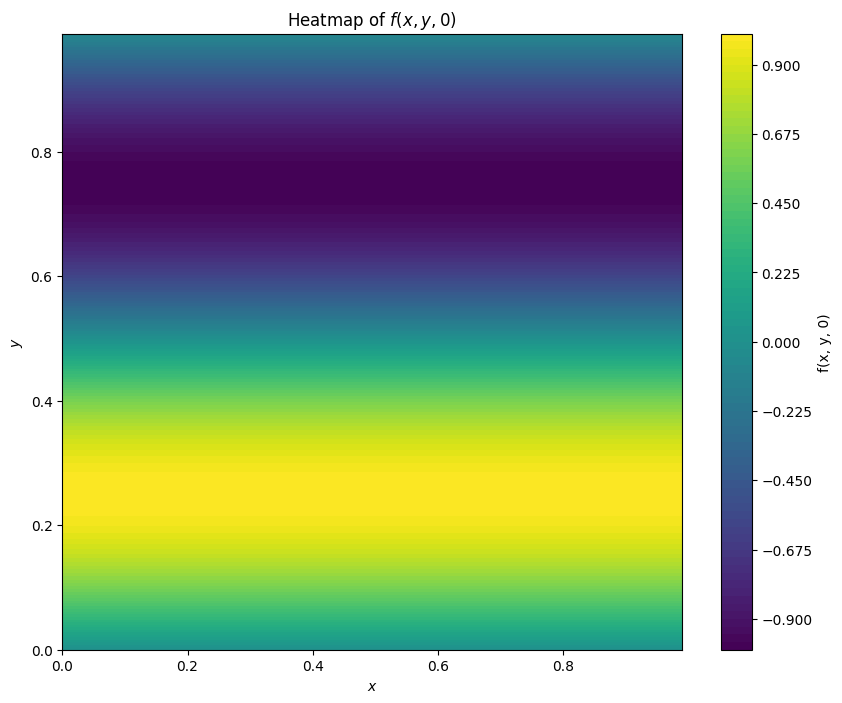

In [343]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], zero_form.scalar_field[:, :, 0], levels=80, cmap='viridis')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [344]:
df.shape

(100, 100, 100, 3)

In [345]:
zero_form.scalar_field.max()

np.float64(1.0)

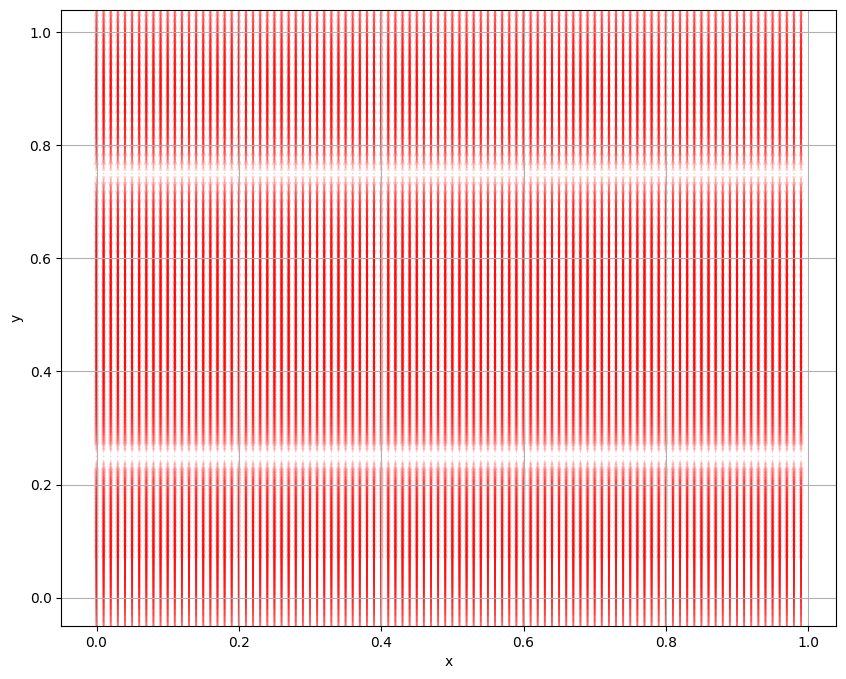

In [346]:
# Plot the scalar field and gradient

plt.figure(figsize=(10, 8))
plt.quiver(V[:, :, 0, 0], V[:, :, 0, 1], df[:, :, 0, 0] * 0.01, df[:, :, 0, 1] * 0.01, color='red', scale=0.5, pivot='middle', alpha=0.2)

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

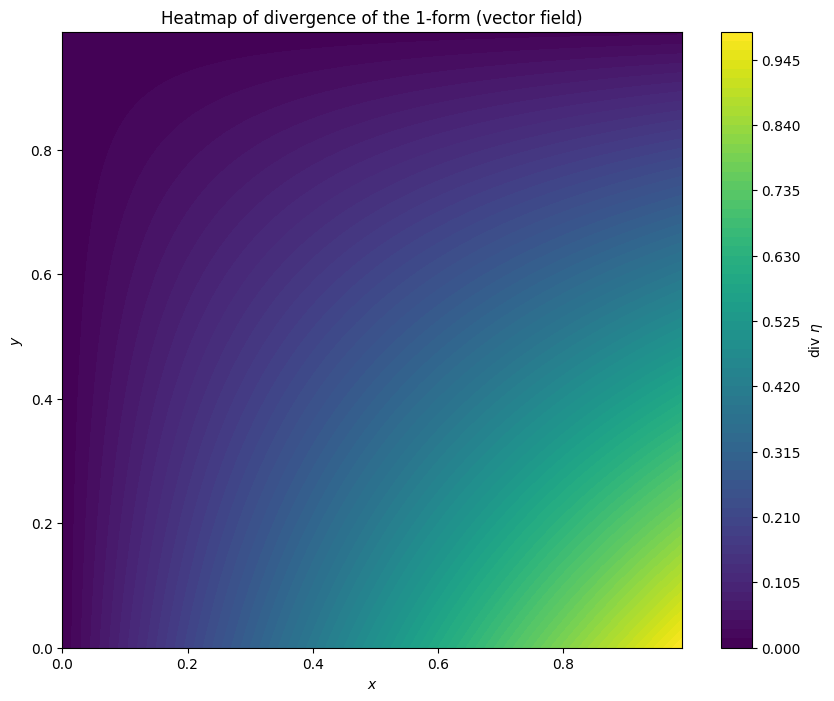

In [347]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], form.divergence()[:, :, 0], levels=80, cmap='viridis')
plt.colorbar(label='div $\eta$')
plt.title('Heatmap of divergence of the 1-form (vector field)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [359]:
def poisson_solve(Phi: np.array) -> np.array:
    Phi_fft = np.fft.fftn(Phi)
    Nx, Ny, Nz = Phi.shape
    # Calculate the necessary frequencies for each dimension:
    K = np.asarray([[[[k_xi / Nx, k_yi / Ny, k_zi / Nz] for k_xi in range(Nx)] for k_yi in range(Ny)] for k_zi in range(Nz)]) * 2 * np.pi
    sin_correction = np.sum(np.sin(K / 2) ** 2, axis = -1) * 4 * np.pi ** 2
    result = Phi_fft / (-sin_correction)
    result[0, 0, 0] = 0 
    result = np.fft.ifftn(result)
    return result

In [360]:
result = poisson_solve(zero_form.scalar_field)
result.shape

/tmp/ipykernel_19828/3912523283.py:7: RuntimeWarning: divide by zero encountered in divide
  result = Phi_fft / (-sin_correction)
/tmp/ipykernel_19828/3912523283.py:7: RuntimeWarning: invalid value encountered in divide
  result = Phi_fft / (-sin_correction)


(100, 100, 100)

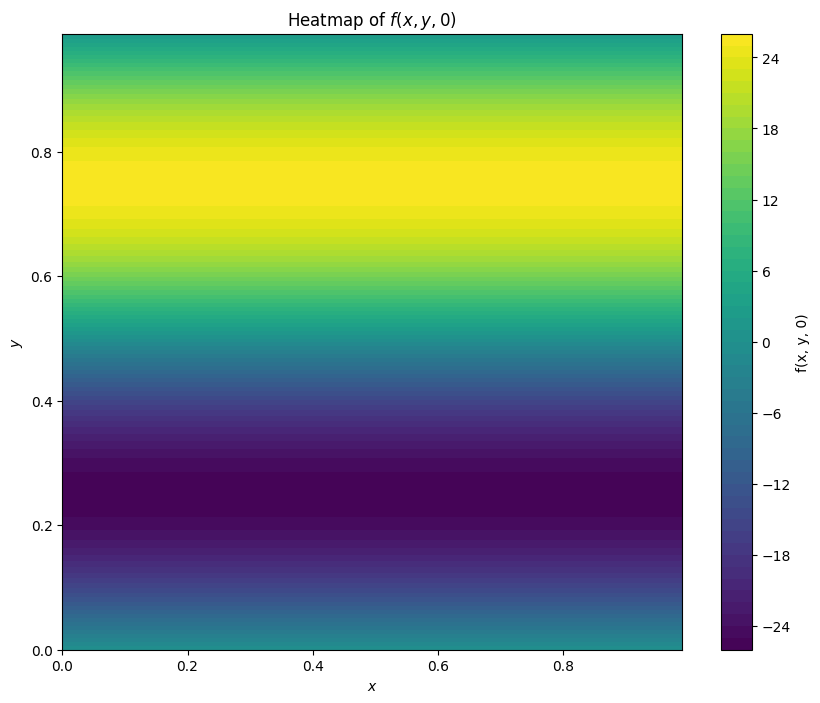

In [362]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], result[:, :, 0].real, levels=60, cmap='viridis')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

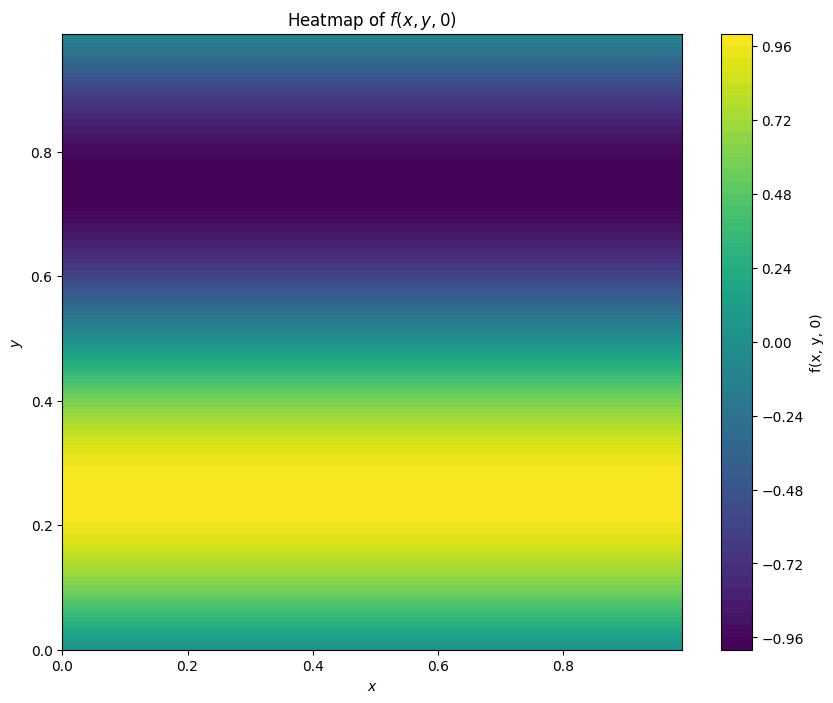

In [363]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], zero_form.scalar_field[:, :, 0], levels=60, cmap='viridis')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

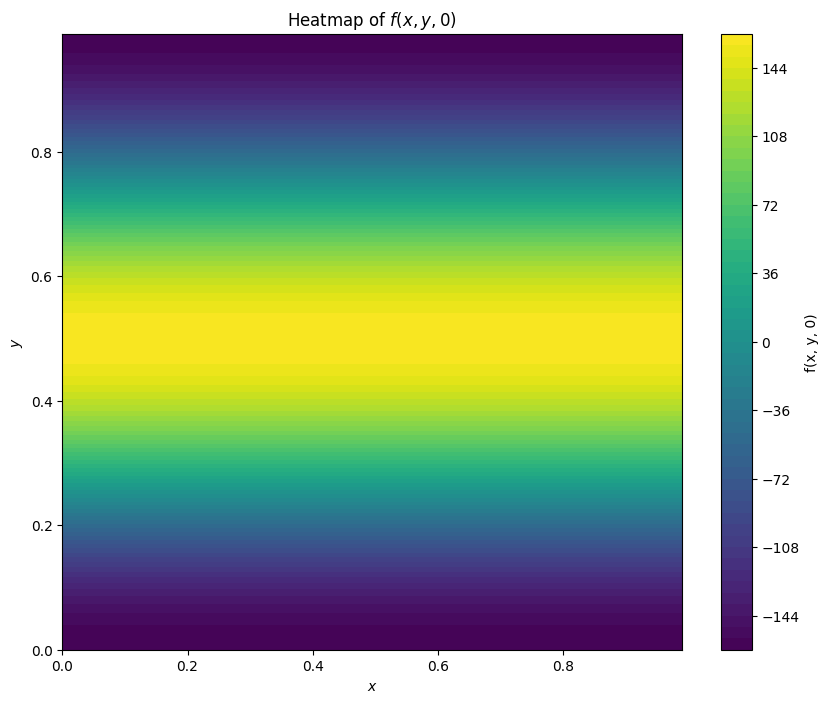

In [364]:
twice_differentiated = OneForm(V_ind[:], vector_field=ZeroForm(V_ind[:], scalar_field=result.real).differentiation()).divergence()
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(V[:, :, 0, 0], V[:, :, 0, 1], twice_differentiated[:, :, 0], levels=60, cmap='viridis')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $f(x, y, 0)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [90]:
def algorithm_1(lambda_hat: np.array, X_0: np.array, X_hat: np.array, tau: float = 0.1) -> np.array:
    assert tau > 0, "hyperparameter tau should be positive."

    Y = X_hat - X_0 - (1 / tau) * lambda_hat
    Y_vectorfield = OneForm(V_ind, vector_field=Y)

    # D^T Y and then solve the poisson equation
    phi = poisson_solve(Y_vectorfield.divergence())
    return phi